# ReadMe
Author: Matthew P. Burruss, April 2020

# Overview

Adversarial attacks add non-random perturbations using the gradient of a model to steer the predictor away from the true class. Adversarial algorithms like Fast Gradient Sign Method (FGSM), Carlini & Wagner adaptive attack, Deep Fool, Projected Gradient Descent, and iterative FGSM (I-FGSM) are white-box attacks in that they can use the gradient of the model to form the adversarial image.

The following notebook is part of Matthew Burruss' Master's Research which continues in part the evaluation of adversarial evaluations performed by [Zadeh et al. 2018](https://arxiv.org/abs/1812.03190) showing the deep radial basis function (RBF) classifiers are more difficult to attack than a regular classifier due to the high non-linearity introduced by the RBF layer. The adversarial attacks are perofrmed using IBM's robustness toolbox which provides an easy and useful API to perform the attacks.

## Data Set
The data set is 10 classes from the ILSRVC2012 challenge and can be found [here](https://drive.google.com/open?id=1UFkNAGmrOdkKwwZHja-7RAgKNny6Qwnh). Each image is normalized and processed using the recommended preprocessing by the creators of [InceptionV3](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html), which was the CNN architecture used in these experiments.

## Getting started

1. Download the data set and upload it to your google drive

2. Download the model weights (softmax_clean.h5 and anomaly_clean.h5) which can be found [here](https://drive.google.com/open?id=1gwt24fyz2gH2qopaY7WZPLP91hCSfNVW).

3. Run the "Connect to Google Drive" cell and then update the "CHANGE ME" cell

4. Update the paths where the third path to update (PATH_TO_SAVE_ADVERSARIAL_ATTACKS) should be an empty folder in your google drive where you would like to store intermediary computations.

5. Execute the rest of the scripts in order!


# Connect to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! pip3 install adversarial-robustness-toolbox==1.0.0
! pip3 install -U keras
! pip3 install tensorflow==1.15.0

# Imports

In [1]:
import os
from art.utils import load_mnist
import cv2
import keras
import keras.backend as K
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,Lambda
from keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, History,ReduceLROnPlateau
from keras.initializers import Initializer
import numpy as np
import tensorflow as tf
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from scipy import stats
from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import losses
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import random
from keras.applications.inception_v3 import preprocess_input
import numpy.linalg as la

Using TensorFlow backend.


# CHANGE ME

In [2]:
%env WEIGHTS_PATH = /content/drive/My Drive/Colab Notebooks/InceptionV3Weights
%env DATASET_PATH = /content/drive/My Drive/Colab Notebooks/dataset.zip
%env PATH_TO_SAVE_ADVERSARIAL_ATTACKS = /content/drive/My Drive/Colab Notebooks/AdversaryAttacks

env: WEIGHTS_PATH=/content/drive/My Drive/Colab Notebooks/InceptionV3Weights
env: DATASET_PATH=/content/drive/My Drive/Colab Notebooks/dataset.zip
env: PATH_TO_SAVE_ADVERSARIAL_ATTACKS=/content/drive/My Drive/Colab Notebooks/AdversaryAttacks


# Copy and unzip the data set into this runtim

In [0]:
! cp -r -v "${DATASET_PATH}" ./
! unzip dataset.zip

# Define the RBF Layer and SoftML Loss Function 

In [0]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1234),
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(0.0)*l2
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        config = {
            'units': self.units,
            'gamma': self.gamma
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

RBF_LAMBDA = 0.5
# this is a helper function
def softargmax(x,beta=1e10):
    """
    Perform argmax in a differential manner
    :param x: An array with the original inputs. `x` is expected to have spatial dimensions.
    :type x: `np.ndarray`
    :param beta: A large number to approximate argmax(`x`)
    :type y: float
    :return: argmax of tensor
    :rtype: `tensorflow.python.framework.ops.Tensor`
    """
    x = tf.convert_to_tensor(x)
    x_range = tf.range(10)
    x_range = tf.dtypes.cast(x_range,tf.float32)
    return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=1)

def RBF_Loss(y_true,y_pred):
    """
    
    :param y_true: 
    :type x: `np.ndarray`
    :param beta: A large number to approximate argmax(`x`)
    :type y: float
    :return: Calculated loss
    :rtype: `tensorflow.python.framework.ops.Tensor`
    """
    lam = RBF_LAMBDA
    indices = softargmax(y_true)
    indices = tf.dtypes.cast(indices,tf.int32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)
    y_true = tf.dtypes.cast(y_true,tf.float32)
    row_ind = K.arange(K.shape(y_true)[0])
    full_indices = tf.stack([row_ind,indices],axis=1)
    d = tf.gather_nd(y_pred,full_indices)
    y_pred = lam - y_pred
    y_pred = tf.nn.relu(y_pred)
    d2 = tf.nn.relu(lam - d)
    S = K.sum(y_pred,axis=1) - d2
    y = K.sum(d + S)
    return y

def RBF_Soft_Loss(y_true,y_pred):
    lam = RBF_LAMBDA
    indices = softargmax(y_true)
    indices = tf.dtypes.cast(indices,tf.int32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)
    y_true = tf.dtypes.cast(y_true,tf.float32)
    row_ind = K.arange(K.shape(y_true)[0])
    full_indices = tf.stack([row_ind,indices],axis=1)
    d = tf.gather_nd(y_pred,full_indices)
    y_pred = K.log(1+ K.exp(lam - y_pred))
    S = K.sum(y_pred,axis=1) - K.log(1+K.exp(lam-d))
    y = K.sum(d + S)
    return y

def DistanceMetric(y_true,y_pred):
    e  = K.equal(K.argmax(y_true,axis=1),K.argmin(y_pred,axis=1))
    s = tf.reduce_sum(tf.cast(e, tf.float32))
    n = tf.cast(K.shape(y_true)[0],tf.float32)
    return s/n

from keras.layers import Conv2D,BatchNormalization,Activation
from keras.regularizers import l2
def ResNetLayer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

# Modified IBM Robustness Keras Classifier
The purpose is to allow the RBF loss function and RBF layer to be included in the calculations of the adversarial image.

In [0]:
# MIT License
#
# Copyright (C) IBM Corporation 2018
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit
# persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
# Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE
# WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
"""
This module implements the classifier `KerasClassifier` for Keras models.
"""
from __future__ import absolute_import, division, print_function, unicode_literals

import logging

import numpy as np
import six

from art.classifiers.classifier import Classifier, ClassifierNeuralNetwork, ClassifierGradients

logger = logging.getLogger(__name__)


class KerasClassifier(ClassifierNeuralNetwork, ClassifierGradients, Classifier):
    """
    Wrapper class for importing Keras models. The supported backends for Keras are TensorFlow and Theano.
    """

    def __init__(self, model, use_logits=False, channel_index=3, clip_values=None, defences=None, preprocessing=(0, 1),
                 input_layer=0, output_layer=0):
        """
        Create a `Classifier` instance from a Keras model. Assumes the `model` passed as argument is compiled.

        :param model: Keras model, neural network or other.
        :type model: `keras.models.Model`
        :param use_logits: True if the output of the model are logits; false for probabilities or any other type of
               outputs. Logits output should be favored when possible to ensure attack efficiency.
        :type use_logits: `bool`
        :param channel_index: Index of the axis in data containing the color channels or features.
        :type channel_index: `int`
        :param clip_values: Tuple of the form `(min, max)` of floats or `np.ndarray` representing the minimum and
               maximum values allowed for features. If floats are provided, these will be used as the range of all
               features. If arrays are provided, each value will be considered the bound for a feature, thus
               the shape of clip values needs to match the total number of features.
        :type clip_values: `tuple`
        :param defences: Defences to be activated with the classifier.
        :type defences: :class:`.Preprocessor` or `list(Preprocessor)` instances
        :param preprocessing: Tuple of the form `(subtractor, divider)` of floats or `np.ndarray` of values to be
               used for data preprocessing. The first value will be subtracted from the input. The input will then
               be divided by the second one.
        :type preprocessing: `tuple`
        :param input_layer: The index of the layer to consider as input for models with multiple input layers. The layer
                            with this index will be considered for computing gradients. For models with only one input
                            layer this values is not required.
        :type input_layer: `int`
        :param output_layer: Which layer to consider as the output when the models has multiple output layers. The layer
                             with this index will be considered for computing gradients. For models with only one output
                             layer this values is not required.
        :type output_layer: `int`
        """
        super(KerasClassifier, self).__init__(clip_values=clip_values, defences=defences,
                                              preprocessing=preprocessing, channel_index=channel_index)

        self._model = model
        self._input_layer = input_layer
        self._output_layer = output_layer

        if '<class \'tensorflow' in str(type(model)):
            self.is_tensorflow = True
        elif '<class \'keras' in str(type(model)):
            self.is_tensorflow = False
        else:
            raise TypeError('Type of model not recognized:' + type(model))

        self._initialize_params(model, use_logits, input_layer, output_layer)

    def _initialize_params(self, model, use_logits, input_layer, output_layer):
        """
        Initialize most parameters of the classifier. This is a convenience function called by `__init__` and
        `__setstate__` to avoid code duplication.

        :param model: Keras model
        :type model: `keras.models.Model`
        :param use_logits: True if the output of the model are logits.
        :type use_logits: `bool`
        :param input_layer: Which layer to consider as the Input when the model has multiple input layers.
        :type input_layer: `int`
        :param output_layer: Which layer to consider as the Output when the model has multiple output layers.
        :type output_layer: `int`
        """
        # pylint: disable=E0401
        if self.is_tensorflow:
            import tensorflow as tf
            if tf.executing_eagerly():
                raise ValueError('TensorFlow is executing eagerly. Please disable eager execution.')
            import tensorflow.keras as keras
            import tensorflow.keras.backend as k
        else:
            import keras
            import keras.backend as k

        if hasattr(model, 'inputs'):
            self._input_layer = input_layer
            self._input = model.inputs[input_layer]
        else:
            self._input = model.input
            self._input_layer = 0

        if hasattr(model, 'outputs'):
            self._output = model.outputs[output_layer]
            self._output_layer = output_layer
        else:
            self._output = model.output
            self._output_layer = 0

        _, self._nb_classes = k.int_shape(self._output)
        self._input_shape = k.int_shape(self._input)[1:]
        logger.debug('Inferred %i classes and %s as input shape for Keras classifier.', self.nb_classes(),
                     str(self.input_shape))

        # Get predictions and loss function
        self._use_logits = use_logits
        if not hasattr(self._model, 'loss'):
            logger.warning('Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.')
            loss_function = k.sparse_categorical_crossentropy
        else:
            if isinstance(self._model.loss, six.string_types):
                try:
                    loss_function = getattr(k, self._model.loss)
                except:
                    loss_function = self._model.loss
            elif self._model.loss.__name__ in ['categorical_hinge', 'kullback_leibler_divergence', 'cosine_proximity']:
                if self.is_tensorflow and self._model.loss.__name__ == 'cosine_proximity':
                    loss_function = tf.keras.losses.cosine_similarity
                else:
                    loss_function = getattr(keras.losses, self._model.loss.__name__)
            else:
                try:
                    loss_function = getattr(k, self._model.loss.__name__)
                except:
                    loss_function = self._model.loss
        
        if loss_function.__name__ in ['categorical_hinge', 'categorical_crossentropy', 'binary_crossentropy',
                                      'kullback_leibler_divergence', 'cosine_proximity','RBF_Soft_Loss','mean_squared_error']:
            self._reduce_labels = False
            label_ph = k.placeholder(shape=self._output.shape)
        elif loss_function.__name__ in ['sparse_categorical_crossentropy']:
            self._reduce_labels = True
            label_ph = k.placeholder(shape=[None, ])
        else:
            raise ValueError('Loss function not recognised.')

        # The implementation of categorical_crossentropy is different in keras and tensorflow.keras. To ensure
        # consistent behavior of `KerasClassifier` for keras and tensorflow.keras we follow the approach of
        # tensorflow.keras for all cases of `from_logits` if the loss_function is categorical_crossentropy.
        if hasattr(self._model, 'loss') and isinstance(self._model.loss, six.string_types) \
                and loss_function.__name__ == 'categorical_crossentropy':
            predictions = self._output
            loss_ = loss_function(label_ph, self._output.op.inputs[-1], from_logits=True)
        elif loss_function.__name__ in ['categorical_hinge', 'cosine_proximity', 'kullback_leibler_divergence']:
            predictions = self._output
            loss_ = loss_function(label_ph, self._output.op.inputs[-1])
        elif loss_function.__name__ in ['RBF_Soft_Loss','mean_squared_error']:
            predictions = self._output
            loss_ = loss_function(label_ph, self._output.op.inputs[-1])
        else:
            predictions = self._output
            loss_ = loss_function(label_ph, self._output, from_logits=use_logits)

        # recent TensorFlow version does not allow a model with an output same as the input.
        if predictions == self._input:
            predictions = k.identity(predictions)

        loss_gradients = k.gradients(loss_, self._input)
        if k.backend() == 'tensorflow':
            loss_gradients = loss_gradients[0]
        elif k.backend() == 'cntk':
            raise NotImplementedError('Only TensorFlow and Theano support is provided for Keras.')

        # Set loss, gradients and prediction functions
        self._predictions_op = predictions
        self._loss = loss_
        self._loss_gradients = k.function([self._input, label_ph], [loss_gradients])
        self._predictions = k.function([self._input], [predictions])

        # Get the internal layer
        self._layer_names = self._get_layers()

    def loss_gradient(self, x, y, **kwargs):
        """
        Compute the gradient of the loss function w.r.t. `x`.

        :param x: Sample input with shape as expected by the model.
        :type x: `np.ndarray`
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,).
        :type y: `np.ndarray`
        :return: Array of gradients of the same shape as `x`.
        :rtype: `np.ndarray`
        """
        # Apply preprocessing
        x_preprocessed, y_preprocessed = self._apply_preprocessing(x, y, fit=False)

        # Adjust the shape of y for loss functions that do not take labels in one-hot encoding
        if self._reduce_labels:
            y_preprocessed = np.argmax(y_preprocessed, axis=1)

        # Compute gradients
        gradients = self._loss_gradients([x_preprocessed, y_preprocessed])[0]
        gradients = self._apply_preprocessing_gradient(x, gradients)
        assert gradients.shape == x_preprocessed.shape

        return gradients

    def class_gradient(self, x, label=None, **kwargs):
        """
        Compute per-class derivatives w.r.t. `x`.

        :param x: Sample input with shape as expected by the model.
        :type x: `np.ndarray`
        :param label: Index of a specific per-class derivative. If an integer is provided, the gradient of that class
                      output is computed for all samples. If multiple values as provided, the first dimension should
                      match the batch size of `x`, and each value will be used as target for its corresponding sample in
                      `x`. If `None`, then gradients for all classes will be computed for each sample.
        :type label: `int` or `list`
        :return: Array of gradients of input features w.r.t. each class in the form
                 `(batch_size, nb_classes, input_shape)` when computing for all classes, otherwise shape becomes
                 `(batch_size, 1, input_shape)` when `label` parameter is specified.
        :rtype: `np.ndarray`
        """
        # Check value of label for computing gradients
        if not (label is None or (isinstance(label, (int, np.integer)) and label in range(self.nb_classes()))
                or (isinstance(label, np.ndarray) and len(label.shape) == 1 and (label < self.nb_classes()).all()
                    and label.shape[0] == x.shape[0])):
            raise ValueError('Label %s is out of range.' % str(label))

        self._init_class_gradients(label=label)

        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        if label is None:
            # Compute the gradients w.r.t. all classes
            gradients = np.swapaxes(np.array(self._class_gradients([x_preprocessed])), 0, 1)

        elif isinstance(label, (int, np.integer)):
            # Compute the gradients only w.r.t. the provided label
            gradients = np.swapaxes(np.array(self._class_gradients_idx[label]([x_preprocessed])), 0, 1)
            assert gradients.shape == (x_preprocessed.shape[0], 1) + self.input_shape

        else:
            # For each sample, compute the gradients w.r.t. the indicated target class (possibly distinct)
            unique_label = list(np.unique(label))
            gradients = np.array([self._class_gradients_idx[l]([x_preprocessed]) for l in unique_label])
            gradients = np.swapaxes(np.squeeze(gradients, axis=1), 0, 1)
            lst = [unique_label.index(i) for i in label]
            gradients = np.expand_dims(gradients[np.arange(len(gradients)), lst], axis=1)

        gradients = self._apply_preprocessing_gradient(x, gradients)

        return gradients

    def predict(self, x, batch_size=128, **kwargs):
        """
        Perform prediction for a batch of inputs.

        :param x: Test set.
        :type x: `np.ndarray`
        :param batch_size: Size of batches.
        :type batch_size: `int`
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`.
        :rtype: `np.ndarray`
        """
        import numpy as np
        NUMPY_DTYPE = np.float32

        # Apply defences
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        # Run predictions with batching
        predictions = np.zeros((x_preprocessed.shape[0], self.nb_classes()), dtype=NUMPY_DTYPE)
        for batch_index in range(int(np.ceil(x_preprocessed.shape[0] / float(batch_size)))):
            begin, end = batch_index * batch_size, min((batch_index + 1) * batch_size, x_preprocessed.shape[0])
            predictions[begin:end] = self._predictions([x_preprocessed[begin:end]])[0]

        return predictions

    def fit(self, x, y, batch_size=128, nb_epochs=20, **kwargs):
        """
        Fit the classifier on the training set `(x, y)`.

        :param x: Training data.
        :type x: `np.ndarray`
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,).
        :type y: `np.ndarray`
        :param batch_size: Size of batches.
        :type batch_size: `int`
        :param nb_epochs: Number of epochs to use for training.
        :type nb_epochs: `int`
        :param kwargs: Dictionary of framework-specific arguments. These should be parameters supported by the
               `fit_generator` function in Keras and will be passed to this function as such. Including the number of
               epochs or the number of steps per epoch as part of this argument will result in as error.
        :type kwargs: `dict`
        :return: `None`
        """
        # Apply preprocessing
        x_preprocessed, y_preprocessed = self._apply_preprocessing(x, y, fit=True)

        # Adjust the shape of y for loss functions that do not take labels in one-hot encoding
        if self._reduce_labels:
            y_preprocessed = np.argmax(y_preprocessed, axis=1)

        gen = generator_fit(x_preprocessed, y_preprocessed, batch_size)
        self._model.fit_generator(gen, steps_per_epoch=x_preprocessed.shape[0] / batch_size, epochs=nb_epochs, **kwargs)

    # def fit_generator(self, generator, nb_epochs=20, **kwargs):
    #     """
    #     Fit the classifier using the generator that yields batches as specified.
    #
    #     :param generator: Batch generator providing `(x, y)` for each epoch. If the generator can be used for native
    #                       training in Keras, it will.
    #     :type generator: :class:`.DataGenerator`
    #     :param nb_epochs: Number of epochs to use for training.
    #     :type nb_epochs: `int`
    #     :param kwargs: Dictionary of framework-specific arguments. These should be parameters supported by the
    #            `fit_generator` function in Keras and will be passed to this function as such. Including the number of
    #            epochs as part of this argument will result in as error.
    #     :type kwargs: `dict`
    #     :return: `None`
    #     """
    #     from art.data_generators import KerasDataGenerator
    #
    #     # Try to use the generator as a Keras native generator, otherwise use it through the `DataGenerator` interface
    #     if isinstance(generator, KerasDataGenerator) and not hasattr(self, 'defences'):
    #         try:
    #             self._model.fit_generator(generator.generator, epochs=nb_epochs, **kwargs)
    #         except ValueError:
    #             logger.info('Unable to use data generator as Keras generator. Now treating as framework-independent.')
    #             super(KerasClassifier, self).fit_generator(generator, nb_epochs=nb_epochs, **kwargs)
    #     else:
    #         super(KerasClassifier, self).fit_generator(generator, nb_epochs=nb_epochs, **kwargs)

    @property
    def layer_names(self):
        """
        Return the hidden layers in the model, if applicable.

        :return: The hidden layers in the model, input and output layers excluded.
        :rtype: `list`

        .. warning:: `layer_names` tries to infer the internal structure of the model.
                     This feature comes with no guarantees on the correctness of the result.
                     The intended order of the layers tries to match their order in the model, but this is not
                     guaranteed either.
        """
        return self._layer_names

    def get_activations(self, x, layer, batch_size):
        """
        Return the output of the specified layer for input `x`. `layer` is specified by layer index (between 0 and
        `nb_layers - 1`) or by name. The number of layers can be determined by counting the results returned by
        calling `layer_names`.

        :param x: Input for computing the activations.
        :type x: `np.ndarray`
        :param layer: Layer for computing the activations
        :type layer: `int` or `str`
        :param batch_size: Size of batches.
        :type batch_size: `int`
        :return: The output of `layer`, where the first dimension is the batch size corresponding to `x`.
        :rtype: `np.ndarray`
        """
        # pylint: disable=E0401
        if self.is_tensorflow:
            import tensorflow.keras.backend as k
        else:
            import keras.backend as k
        from art import NUMPY_DTYPE

        if isinstance(layer, six.string_types):
            if layer not in self._layer_names:
                raise ValueError('Layer name %s is not part of the graph.' % layer)
            layer_name = layer
        elif isinstance(layer, int):
            if layer < 0 or layer >= len(self._layer_names):
                raise ValueError('Layer index %d is outside of range (0 to %d included).'
                                 % (layer, len(self._layer_names) - 1))
            layer_name = self._layer_names[layer]
        else:
            raise TypeError('Layer must be of type `str` or `int`.')

        layer_output = self._model.get_layer(layer_name).output
        output_func = k.function([self._input], [layer_output])

        if x.shape == self.input_shape:
            x_expanded = np.expand_dims(x, 0)
        else:
            x_expanded = x

        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x=x_expanded, y=None, fit=False)

        assert len(x_preprocessed.shape) == 4

        # Determine shape of expected output and prepare array
        output_shape = output_func([x_preprocessed[0][None, ...]])[0].shape
        activations = np.zeros((x_preprocessed.shape[0],) + output_shape[1:], dtype=NUMPY_DTYPE)

        # Get activations with batching
        for batch_index in range(int(np.ceil(x_preprocessed.shape[0] / float(batch_size)))):
            begin, end = batch_index * batch_size, min((batch_index + 1) * batch_size, x_preprocessed.shape[0])
            activations[begin:end] = output_func([x_preprocessed[begin:end]])[0]

        return activations

    def _init_class_gradients(self, label=None):
        # pylint: disable=E0401
        if self.is_tensorflow:
            import tensorflow.keras.backend as k
        else:
            import keras.backend as k

        if len(self._output.shape) == 2:
            nb_outputs = self._output.shape[1]
        else:
            raise ValueError('Unexpected output shape for classification in Keras model.')

        if label is None:
            logger.debug('Computing class gradients for all %i classes.', self.nb_classes())
            if not hasattr(self, '_class_gradients'):
                class_gradients = [k.gradients(self._predictions_op[:, i], self._input)[0] for i in range(nb_outputs)]
                self._class_gradients = k.function([self._input], class_gradients)

        else:
            if isinstance(label, int):
                unique_labels = [label]
            else:
                unique_labels = np.unique(label)
            logger.debug('Computing class gradients for classes %s.', str(unique_labels))

            if not hasattr(self, '_class_gradients_idx'):
                self._class_gradients_idx = [None for _ in range(nb_outputs)]

            for current_label in unique_labels:
                if self._class_gradients_idx[current_label] is None:
                    class_gradients = [k.gradients(self._predictions_op[:, current_label], self._input)[0]]
                    self._class_gradients_idx[current_label] = k.function([self._input], class_gradients)

    def _get_layers(self):
        """
        Return the hidden layers in the model, if applicable.

        :return: The hidden layers in the model, input and output layers excluded.
        :rtype: `list`
        """
        # pylint: disable=E0401
        if self.is_tensorflow:
            from tensorflow.keras.layers import InputLayer
        else:
            from keras.engine.topology import InputLayer

        layer_names = [layer.name for layer in self._model.layers[:-1] if not isinstance(layer, InputLayer)]
        logger.info('Inferred %i hidden layers on Keras classifier.', len(layer_names))

        return layer_names

    def set_learning_phase(self, train):
        """
        Set the learning phase for the backend framework.

        :param train: True to set the learning phase to training, False to set it to prediction.
        :type train: `bool`
        """
        # pylint: disable=E0401
        if self.is_tensorflow:
            import tensorflow.keras.backend as k
        else:
            import keras.backend as k

        if isinstance(train, bool):
            self._learning_phase = train
            k.set_learning_phase(int(train))

    def nb_classes(self):
        """
        Return the number of output classes.

        :return: Number of classes in the data.
        :rtype: `int`
        """
        return self._nb_classes

    def save(self, filename, path=None):
        """
        Save a model to file in the format specific to the backend framework. For Keras, .h5 format is used.

        :param filename: Name of the file where to store the model.
        :type filename: `str`
        :param path: Path of the folder where to store the model. If no path is specified, the model will be stored in
                     the default data location of the library `DATA_PATH`.
        :type path: `str`
        :return: None
        """
        import os

        if path is None:
            from art import DATA_PATH
            full_path = os.path.join(DATA_PATH, filename)
        else:
            full_path = os.path.join(path, filename)
        folder = os.path.split(full_path)[0]
        if not os.path.exists(folder):
            os.makedirs(folder)

        self._model.save(str(full_path))
        logger.info('Model saved in path: %s.', full_path)

    def __getstate__(self):
        """
        Use to ensure `KerasClassifier` can be pickled.

        :return: State dictionary with instance parameters.
        :rtype: `dict`
        """
        import time

        state = self.__dict__.copy()

        # Remove the unpicklable entries
        del state['_model']
        del state['_input']
        del state['_output']
        del state['_predictions_op']
        del state['_loss']
        del state['_loss_gradients']
        del state['_predictions']
        del state['_layer_names']

        model_name = str(time.time()) + '.h5'
        state['model_name'] = model_name
        self.save(model_name)
        return state

    def __setstate__(self, state):
        """
        Use to ensure `KerasClassifier` can be unpickled.

        :param state: State dictionary with instance parameters to restore.
        :type state: `dict`
        """
        self.__dict__.update(state)

        # Load and update all functionality related to Keras
        # pylint: disable=E0401
        import os
        from art import DATA_PATH
        if self.is_tensorflow:
            from tensorflow.keras.models import load_model
        else:
            from keras.models import load_model

        full_path = os.path.join(DATA_PATH, state['model_name'])
        model = load_model(str(full_path))

        self._model = model
        self._initialize_params(model, state['_use_logits'], state['_input_layer'], state['_output_layer'])

    def __repr__(self):
        repr_ = "%s(model=%r, use_logits=%r, channel_index=%r, clip_values=%r, defences=%r, preprocessing=%r, " \
                "input_layer=%r, output_layer=%r)" \
                % (self.__module__ + '.' + self.__class__.__name__,
                   self._model, self._use_logits, self.channel_index, self.clip_values, self.defences,
                   self.preprocessing, self._input_layer, self._output_layer)

        return repr_


def generator_fit(x, y, batch_size=128):
    """
    Minimal data generator for randomly batching large datasets.

    :param x: The data sample to batch.
    :type x: `np.ndarray`
    :param y: The labels for `x`. The first dimension has to match the first dimension of `x`.
    :type y: `np.ndarray`
    :param batch_size: The size of the batches to produce.
    :type batch_size: `int`
    :return: A batch of size `batch_size` of random samples from `(x, y)`
    :rtype: `tuple(np.ndarray, np.ndarray)`
    """
    while True:
        indices = np.random.randint(x.shape[0], size=batch_size)
        yield x[indices], y[indices]


# Define the InceptionV3 Wrapper Model

In [0]:
from keras.applications.inception_v3 import InceptionV3
class InceptionV3Model():
    def __init__(self,num_classes=10,RBF=False,anomalyDetector=False,weights=None):
        self.input_size = (299, 299, 3)
        self.num_classes = num_classes
        self.isRBF = RBF
        self.isAnomalyDetector = anomalyDetector
        assert not (self.isRBF and self.isAnomalyDetector),\
            print('Cannot init RBF and anomaly detector')
        model = InceptionV3(include_top = True, weights=weights,classes=1000)
        if (RBF):
            outputs = Dense(64,activation='tanh')(model.layers[-2].output)
            outputs = RBFLayer(10,0.5)(outputs)
            model = Model(inputs=model.inputs, outputs=outputs)
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        elif(anomalyDetector):
            outputs = Activation('tanh')(model.layers[-2].output)
            outputs = RBFLayer(10,0.5)(outputs)
            model = Model(inputs=model.inputs, outputs=outputs)
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        else:
            outputs = Dense(10,activation='softmax')(model.layers[-2].output)
            model = Model(inputs=model.inputs, outputs=outputs)
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        self.model = model

    def predict(self,X):
        predictions = self.model.predict(X)
        if (self.isRBF or self.isAnomalyDetector):
            lam = RBF_LAMBDA
            Ok = np.exp(-1*predictions)
            top = Ok*(1+np.exp(lam)*Ok)
            bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
            predictions = np.divide(top.T,bottom).T
        return predictions

    def train(self,train_data_generator,validation_data_generator,saveTo,epochs=10):
        if (self.isRBF or self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        self.model.fit_generator(
            train_data_generator,
            steps_per_epoch = math.ceil(train_data_generator.samples/train_data_generator.batch_size),
            epochs = epochs,
            validation_data = validation_data_generator,
            validation_steps = math.ceil(validation_data_generator.samples/validation_data_generator.batch_size),
            callbacks = [checkpoint])

    def load(self,weights):
        if (self.isRBF or self.isAnomalyDetector):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
        else:
            self.model = load_model(weights)

    def evaluate(self,X,Y):
        predictions = self.predict(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        print('Number of samples: ', len(Y))

    def reject(self,X):
        assert self.isRBF or self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        return 1.0/bottom


# Define methods to load the data and perform basic data augmentation

In [7]:
imagenet_baseDir = './vgg16_dataset_10_partitioned'
def preprocess(x):
    x = preprocess_input(x)
    x = x/255.
    return x

def loadData(baseDir,dataType='train'):
    assert dataType in ['train','test','val'],\
        print('Not a valid type, must be train, test, or val')
    train_data_dir = os.path.join(baseDir,dataType)
    if (dataType=='test'):
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess)
        data_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size = (299,299),
            batch_size = 32,
            class_mode = "categorical",
            shuffle=True)
        data_generator.batch_size = data_generator.samples
    else:
        datagen = ImageDataGenerator(
            fill_mode = "nearest",
            zoom_range = 0.3,
            width_shift_range = 0.3,
            height_shift_range=0.3,
            rotation_range=30,
            horizontal_flip=True,
            preprocessing_function=preprocess)
        data_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size = (299,299),
            batch_size = 32,
            class_mode = "categorical",
            shuffle=True)
    return data_generator

print('Loading training data generator...')
train_data_generator = loadData(baseDir=imagenet_baseDir,dataType='train')
print('Loading validation data generator...')
validation_data_generator = loadData(baseDir=imagenet_baseDir,dataType='val')
print('Loading test data generator...')
test_data_generator = loadData(baseDir=imagenet_baseDir,dataType='test')

Loading training data generator...
Found 9090 images belonging to 10 classes.
Loading validation data generator...
Found 1950 images belonging to 10 classes.
Loading test data generator...
Found 1960 images belonging to 10 classes.


# Load or train softmax and rbf model

In [0]:
# SOFTMAX MODEL CLEAN
softmax_clean = InceptionV3Model(weights=None,RBF=False)
#softmax_clean.model.summary()
softmax_clean.load(weights=os.path.join(os.environ['WEIGHTS_PATH'],'softmax_clean.h5'))
#softmax_clean.train(train_data_generator,validation_data_generator,saveTo=os.path.join(baseDir,'softmax_clean.h5'),epochs=100)
print('Loaded softmax clean model...')
softmax_clean.model.summary()
# ANOMALY DETECTOR CLEAN
anomaly_clean = InceptionV3Model(weights=None,anomalyDetector=True)
#anomaly_clean.model.summary()
anomaly_clean.load(weights=os.path.join(os.environ['WEIGHTS_PATH'],'anomaly_clean.h5'))
#K.set_value(anomaly_clean.model.optimizer.lr,0.0001)
#anomaly_clean.train(train_data_generator,validation_data_generator,saveTo=os.path.join(baseDir,'anomaly_clean.h5'),epochs=100)
print('loaded anomaly clean model...')

# Evaluate the models on the clean test data

In [9]:
x_test,y_test = test_data_generator.next()
print('Number of test data',y_test.shape[0])
print('SOFTMAX CLEAN on test')
softmax_clean.evaluate(x_test,y_test)
print('\n')
print('ANOMALY CLEAN on test')
anomaly_clean.evaluate(x_test,y_test)

Number of test data 1960
SOFTMAX CLEAN on test
The accuracy of the model:  0.7994897959183673
Number of samples:  1960


ANOMALY CLEAN on test
The accuracy of the model:  0.7811224489795918
Number of samples:  1960


# Define helper functions to perform the adversarial attacks

In [0]:
# distortion measure
from art.attacks import FastGradientMethod,DeepFool,CarliniL2Method,BasicIterativeMethod,ProjectedGradientDescent
def calc_distortion(X1,X2):
    n = X1.shape[0]
    return np.sqrt(np.sum(np.square(X1.reshape(n,299*299*3)-X2.reshape(n,299*299*3)),axis=1)/n)

# L2 norm metric (similar to distortion)
def calc_l2normperturbation(model,xadv,x_clean,y_clean):
    predictions_adv = model.predict(xadv)
    predictions_clean = model.predict(x_clean)
    adv_labels = np.argmax(predictions_adv,axis=1)
    clean_labels = np.argmax(y_clean,axis=1)
    pred_labels = np.argmax(predictions_clean,axis=1)
    idxs = np.logical_and(adv_labels != clean_labels,pred_labels==clean_labels)
    if np.sum(idxs) == 0.0:
        print('No incorrect predictions!')
        return 0
    norm_type = 2
    perts_norm = la.norm((xadv - x_clean).reshape(x_clean.shape[0], -1), ord=norm_type, axis=1)
    perts_norm = perts_norm[idxs]
    mu= np.mean(perts_norm)
    maximum= np.max(perts_norm)
    minimum= np.min(perts_norm)
    return mu,maximum,minimum

# c&w attack
def CarliniWagnerAttack(model,X,path=None):
    classifier = KerasClassifier(defences=[],model=model, use_logits=False)
    print('Designing adversarial images for Carlini Wagner Attack...')
    if os.path.isfile(path):
        xadv = np.load(path)
    else:
        attack = CarliniL2Method(classifier=classifier)
        xadv = attack.generate(x=np.copy(X))
        if (path != None):
            np.save(path,xadv)
            print('Saved x_test_adv: ', path)
    return xadv

#pgd attack
def ProjectedGradientDescentAttack(model,X,path=None):
    classifier = KerasClassifier(defences=[],model=model, use_logits=False)
    print('Designing adversarial images Projected Gradient Descent...')
    if os.path.isfile(path):
        xadv = np.load(path)
    else:
        attack = ProjectedGradientDescent(classifier=classifier,eps=0.0001,eps_step=0.0001)
        xadv = attack.generate(x=np.copy(X))
        if (path != None):
            np.save(path,xadv)
            print('Saved x_test_adv: ', path)
    return xadv

#fgsm attack
def FGSMAttack(model,X,path=None,eps=0.0001,eps_step=0.0001):
    classifier = KerasClassifier(defences=[],model=model, use_logits=False)
    print('Designing adversarial images FGSM...')
    if os.path.isfile(path):
        print('loading fgsm')
        xadv = np.load(path)
    else:
        attack = FastGradientMethod(classifier=classifier,eps=eps,eps_step=eps_step)
        xadv = attack.generate(x=np.copy(X))
        if (path != None):
            np.save(path,xadv)
            print('Saved x_test_adv: ', path)
    return xadv

#deepfool attack
def DeepFoolAttack(model,X,path=None):
    classifier = KerasClassifier(defences=[],model=model, use_logits=False)
    print('Designing adversarial images DeepFool...')
    if os.path.isfile(path):
        xadv = np.load(path)
    else:
        attack = DeepFool(classifier=classifier)
        xadv = attack.generate(x=np.copy(X))
        if (path != None):
            np.save(path,xadv)
            print('Saved x_test_adv: ', path)
    return xadv

#ifgsm attack
def BasicIterativeMethodAttack(model,X,path=None):
    classifier = KerasClassifier(defences=[],model=model, use_logits=False)
    print('Designing adversarial images iterative fgsm...')
    if os.path.isfile(path):
        xadv = np.load(path)
    else:
        attack = BasicIterativeMethod(classifier=classifier,eps=0.0001,eps_step=0.0001)
        xadv = attack.generate(x=np.copy(X))
        if (path != None):
            np.save(path,xadv)
            print('Saved x_test_adv: ', path)
    return xadv

# unprocess adversarial image for viewing
def unprocess(X):
    X *= 255.
    X /= 2.
    X += 0.5
    X *= 255.
    return X

# Perform the adversarial attacks on the two models

In [0]:
# PARAMETERS
# Below, set true to the attacks you would like to evaluate
FGSM = True
Deepfool = True
IFGSM = True
CarliniWagner = True
PGD = True
# Specify the number of adversarial images to produce per attack
sizeOfAttack=10 

# Shouldn't need to change below
######################################################################
attackBaseDir = os.environ['PATH_TO_SAVE_ADVERSARIAL_ATTACKS']
attacks=[]
if (FGSM):
    attacks.append({
        'name':'fgsm',
        'function': FGSMAttack,
        'title': 'FGSM Attack'})
if (Deepfool):
    attacks.append({
        'name':'deepfool',
        'function': DeepFoolAttack,
        'title': 'Deep Fool Attack'})
if (IFGSM):
    attacks.append({
        'name':'ifgsm',
        'function': BasicIterativeMethodAttack,
        'title': 'I-FGSM Attack'})
if (CarliniWagner):
    attacks.append({
        'name':'c&w',
        'function': CarliniWagnerAttack,
        'title': 'Carlini & Wagner Attack'})
if (PGD):
    attacks.append({
        'name':'pgd',
        'function': ProjectedGradientDescentAttack,
        'title': 'Projected Gradient Descent Attack'})
print('Performing the following attacks...')
for attack in attacks:
    print(attack['name'],end=' ')
print('')

print('Load the x and y data set if they already exist...')
if not os.path.isfile(os.path.join(attackBaseDir,'x_test_clean.npy')):
    np.save(os.path.join(attackBaseDir,'x_test_clean.npy'),x_test[0:sizeOfAttack])
    x = x_test[0:sizeOfAttack]
else:
    x = np.load(os.path.join(attackBaseDir,'x_test_clean.npy'))
    print('Loading x test data: Already designed adversary images.')
if not os.path.isfile(os.path.join(attackBaseDir,'y_test_clean.npy')):
    np.save(os.path.join(attackBaseDir,'y_test_clean.npy'),y_test[0:sizeOfAttack])
    y = y_test[0:sizeOfAttack]
else:
    y = np.load(os.path.join(attackBaseDir,'y_test_clean.npy'))
    print('Loading y test data: Already designed adversary images.')

for attack in attacks:
    attackName = attack['name']
    title = attack['title']
    print('Evaluating Attack:',attackName)
    attack_function = attack['function']
    print('Attacking softmax model...')
    if not os.path.isdir(os.path.join(attackBaseDir,attackName)):
      os.mkdir(os.path.join(attackBaseDir,attackName))
    for model_name in ['softmax','anomaly']:
      if model_name == 'softmax':
        model_wrapper = softmax_clean
      elif model_name == 'anomaly':
        model_wrapper = anomaly_clean
      else:
        raise ValueError('Model doesn\'t exist!')
      xadv = attack_function(model=model_wrapper.model,
          X=np.copy(x),
          path=os.path.join(attackBaseDir,attackName,'{}_attack.npy'.format(model_name)))
      print('{} models performance on {} attack...'.format(model_name,attackName))
      model_wrapper.evaluate(xadv,y)
      P1 = model_wrapper.predict(xadv)
      confidence = P1[np.arange(P1.shape[0]),np.argmax(P1,axis=1)]
      print('{} model average confidence: {:.2}'.format(model_name,np.mean(confidence)))



# Evaluate the Attacks

In [0]:
# PARAMETERS
# Which attacks to evaluate
FGSM = True
Deepfool = True
IFGSM = True
CarliniWagner = True
PGD = True

def calc_true_and_false_positive(model,xadv,x_clean,y_clean):
    predictions_adv = model.predict(xadv)
    predictions_clean = model.predict(x_clean)
    adv_labels = np.argmax(predictions_adv,axis=1)
    clean_labels = np.argmax(y_clean,axis=1)
    pred_labels = np.argmax(predictions_clean,axis=1)
    true_positive_idx = np.where(np.logical_and(adv_labels != clean_labels,pred_labels==clean_labels))[0]
    true_positive_rate = len(true_positive_idx) / len(clean_labels)
    incorrect_label_idx = adv_labels[true_positive_idx]
    incorrect_predictions_adv = predictions_adv[true_positive_idx]
    TP_Mean_Confidence_adv = np.mean(incorrect_predictions_adv[np.arange(incorrect_predictions_adv.shape[0]),incorrect_label_idx])
    incorrect_label_idx = clean_labels[true_positive_idx]
    incorrect_predictions_clean = predictions_clean[true_positive_idx]
    TP_Mean_Confidence_clean = np.mean(incorrect_predictions_clean[np.arange(incorrect_predictions_clean.shape[0]),incorrect_label_idx])
    false_positive_idx = np.where(np.logical_and(adv_labels != clean_labels,pred_labels!=clean_labels))[0]
    false_positive_rate = len(false_positive_idx) / len(clean_labels)
    return true_positive_rate,false_positive_rate,TP_Mean_Confidence_adv,TP_Mean_Confidence_clean

def calc_l2normperturbation(model,xadv,x_clean,y_clean):
    predictions_adv = model.predict(xadv)
    predictions_clean = model.predict(x_clean)
    adv_labels = np.argmax(predictions_adv,axis=1)
    clean_labels = np.argmax(y_clean,axis=1)
    pred_labels = np.argmax(predictions_clean,axis=1)
    idxs = np.logical_and(adv_labels != clean_labels,pred_labels==clean_labels)
    if np.sum(idxs) == 0.0:
        print('No incorrect predictions!')
        return 0,0,0
    norm_type = 2
    perts_norm = la.norm((xadv - x_clean).reshape(x_clean.shape[0], -1), ord=norm_type, axis=1)
    perts_norm = perts_norm[idxs]
    mu= np.mean(perts_norm)
    maximum= np.max(perts_norm)
    minimum= np.min(perts_norm)
    return mu,maximum,minimum

attacks=[]
if (FGSM):
  attacks.append({
      'name':'fgsm',
      'function': FGSMAttack,
      'title': 'FGSM Attack'})
if (Deepfool):
  attacks.append({
      'name':'deepfool',
      'function': DeepFoolAttack,
      'title': 'Deep Fool Attack'})
if (IFGSM):
  attacks.append({
      'name':'ifgsm',
      'function': BasicIterativeMethodAttack,
      'title': 'I-FGSM Attack'})
if (CarliniWagner):
  attacks.append({
      'name':'c&w',
      'function': CarliniWagnerAttack,
      'title': 'Carlini & Wagner Attack'})
if (PGD):
  attacks.append({
      'name':'pgd',
      'function': ProjectedGradientDescentAttack,
      'title': 'Projected Gradient Descent Attack'})

print('Evaluating the following attacks...')
for attack in attacks:
    print(attack['name'],end=' ')
print('')

assert os.path.isfile(os.path.join(attackBaseDir,'x_test_clean.npy')), \
    print('Not a path')
assert os.path.isfile(os.path.join(attackBaseDir,'y_test_clean.npy')), \
    print('Not a path')
x = np.load(os.path.join(attackBaseDir,'x_test_clean.npy'))
y = np.load(os.path.join(attackBaseDir,'y_test_clean.npy'))

for attack in attacks:
  attackName = attack['name']
  title = attack['title']
  print('Evaluating Attack:',attackName)
  attack_function = attack['function']
  xadv_softmax = attack_function(model=softmax_clean.model,
      X=np.copy(x),
      path=os.path.join(attackBaseDir,attackName,'softmax_attack.npy'))
  print('Loading attack for rbf classifier...')
  xadv_rbf = attack_function(model=anomaly_clean.model,
      X=np.copy(x),
      path=os.path.join(attackBaseDir,attackName,'anomaly_attack.npy'))
  print("#################################################")
  print('\nEvaluating TP and FP on softmax')
  TP,FP,TP_Mean_Adv,TP_Mean_Clean = calc_true_and_false_positive(softmax_clean,xadv_softmax,np.copy(x),np.copy(y))
  print('TP:',TP)
  print('FP:',FP)
  print('Mean Confidence TP Adversary',TP_Mean_Adv)
  print('Mean Confidence TP Adversary',TP_Mean_Clean)
  print('\nEvaluating transferability TP and FP on softmax')
  TP,FP,TP_Mean,TP_Mean_Clean = calc_true_and_false_positive(softmax_clean,xadv_rbf,np.copy(x),np.copy(y))
  print('Transferability TP:',TP)
  print('Transferability FP:',FP)
  print('\nEvaluating average l2 norm...')
  mu,maximum,minimum = calc_l2normperturbation(softmax_clean,xadv_softmax,np.copy(x),np.copy(y))
  print('L2 perturbation normalized:mean',mu)
  print('L2 perturbation normalized:maximimum',maximum)
  print('L2 perturbation normalized:minimum',minimum)
  print('\nEvaluating Accuracy on regular samples softmax..')
  softmax_clean.evaluate(x,y)
  print("#################################################")
  print('\nEvaluating TP and FP on Anomaly')
  TP,FP,TP_Mean_Adv,TP_Mean_Clean = calc_true_and_false_positive(anomaly_clean,xadv_rbf,np.copy(x),np.copy(y))
  print('TP:',TP)
  print('FP:',FP)
  print('Mean Confidence TP Adversary',TP_Mean_Adv)
  print('Mean Confidence TP Adversary',TP_Mean_Clean)
  print('\nEvaluating transferability TP and FP on softmax')
  TP,FP,TP_Mean,TP_Mean_Clean = calc_true_and_false_positive(anomaly_clean,xadv_softmax,np.copy(x),np.copy(y))
  print('Transferability TP:',TP)
  print('Transferability FP:',FP)
  print('\nEvaluating average l2 norm...')
  mu,maximum,minimum = calc_l2normperturbation(anomaly_clean,xadv_rbf,np.copy(x),np.copy(y))
  print('L2 perturbation normalized:mean',mu)
  print('L2 perturbation normalized:maximimum',maximum)
  print('L2 perturbation normalized:minimum',minimum)
  print('\nEvaluating Accuracy on regular samples rbf..')
  anomaly_clean.evaluate(x,y)

# Visualizations

## See what various epsilons do to the FGSM algorithm

In [0]:
! rm -rf /content/images
! mkdir /content/images
path = './'
eps = np.array([0.00001,0.00009,0.0005,0.001,0.005,0.01])
eps_step = eps/2
softmax_acc = []
softmax_distortion = []
rbf_acc = []
rbf_distortion = []
distortions = []
test_data_generator.batch_size = 10
confidence_of_rejection = []
confidence_of_clean = []
for i in range(len(eps)):
  x_test,y_test = test_data_generator.next()
  for j in range(2):
    if j == 1:
      model = softmax_clean.model
      print('softmax')
    else:
      model = anomaly_clean.model
      print('anomaly')
    xadv = FGSMAttack(model,x_test,path=path,eps=eps[i],eps_step=eps_step[i])
    distortion = calc_distortion(xadv,x_test) 
    softmax_acc.append(np.sum(np.argmax(softmax_clean.predict(xadv),axis=1) == np.argmax(y_test,axis=1)) / len(y_test))
    rbf_acc.append(np.sum(np.argmax(anomaly_clean.predict(xadv),axis=1) == np.argmax(y_test,axis=1)) / len(y_test))
    reject_adv = anomaly_clean.reject(xadv)
    reject_clean = anomaly_clean.reject(x_test)
    confidence_of_rejection.append([np.mean(reject_adv),np.std(reject_adv)])
    confidence_of_clean.append([np.mean(reject_clean),np.std(reject_clean)])
    distortions.append([np.mean(distortion),np.std(distortion)])
    unprocessed_x = unprocess(np.copy(x_test)).astype(np.uint8)
    plt.imsave('/content/images/'+'orig_' + str(i+j*6)+'_distortion_' + str(distortion[0])+'.png',unprocessed_x[0])
    plt.imshow(unprocessed_x[0])
    plt.show()
    xadv = unprocess(np.copy(xadv)).astype(np.uint8)
    plt.imsave('/content/images/'+'adv_' + str(i+j*6)+'_distortion_' + str(distortion[0])+'.png',xadv[0])
    plt.imshow(xadv[0])
    plt.show()


# Perform FGSM attack with various epsilons and store results

In [41]:
! mkdir /content/images
eps = np.array([0.00001,0.00004,0.00009,0.0001,0.0005,0.0009,0.001,0.005,0.01])
eps_step = eps/2
softmax_acc = []
softmax_distortion = []
rbf_acc = []
rbf_distortion = []
distortions = []
test_data_generator.batch_size = 100
confidence_of_rejection = []
confidence_of_clean = []
for j in range(2):
  if j == 1:
    model = softmax_clean.model
  else:
    model = anomaly_clean.model
  for i in range(len(eps)):
    x_test,y_test = test_data_generator.next()
    xadv = FGSMAttack(model,x_test,path=path,eps=eps[i],eps_step=eps_step[i])
    distortion = calc_distortion(xadv,x_test) 
    softmax_acc.append(np.sum(np.argmax(softmax_clean.predict(xadv),axis=1) == np.argmax(y_test,axis=1)) / len(y_test))
    rbf_acc.append(np.sum(np.argmax(anomaly_clean.predict(xadv),axis=1) == np.argmax(y_test,axis=1)) / len(y_test))
    reject_adv = anomaly_clean.reject(xadv)
    reject_clean = anomaly_clean.reject(x_test)
    confidence_of_rejection.append([np.mean(reject_adv),np.std(reject_adv)])
    confidence_of_clean.append([np.mean(reject_clean),np.std(reject_clean)])
    distortions.append([np.mean(distortion),np.std(distortion)])
    x_test = unprocess(np.copy(x_test)).astype(np.uint8)
# Store results for later use
confidence_of_rejection = np.array(confidence_of_rejection)
distortions = np.array(distortions)
rbf_acc = np.array(rbf_acc)
softmax_acc = np.array(softmax_acc)
confidence_of_clean = np.array(confidence_of_clean)
np.save(os.path.join(attackBaseDir,'softmax_acc.npy'),softmax_acc)
np.save(os.path.join(attackBaseDir,'rbf_acc.npy'),rbf_acc)
np.save(os.path.join(attackBaseDir,'confidence_of_rejection.npy'),confidence_of_rejection)
np.save(os.path.join(attackBaseDir,'confidence_of_clean.npy'),confidence_of_clean)
np.save(os.path.join(attackBaseDir,'distortions.npy'),distortions)

Saved x_test_adv:  ./


# Perform random noise attack and store results

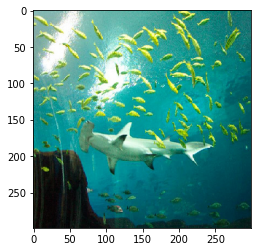

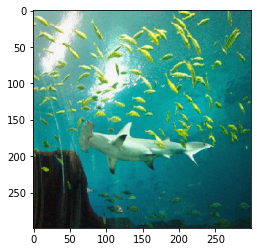

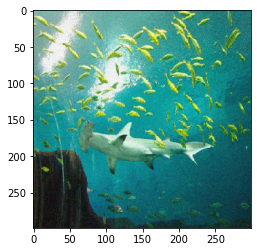

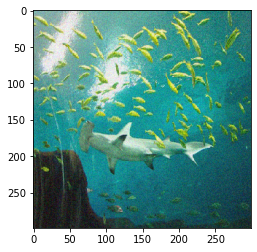

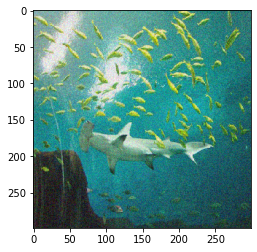

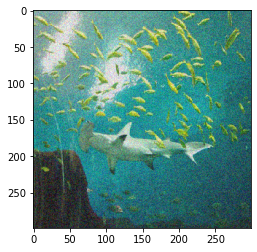

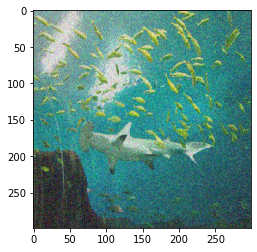

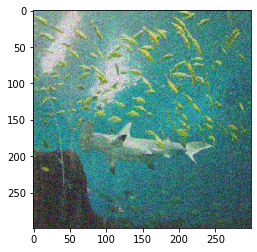

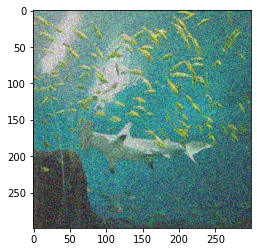

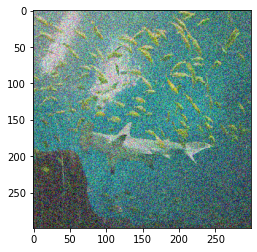

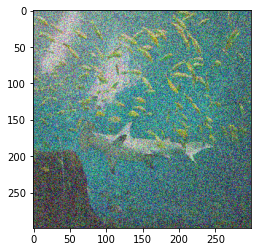

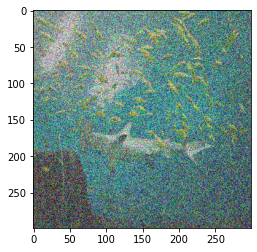

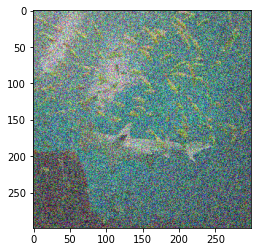

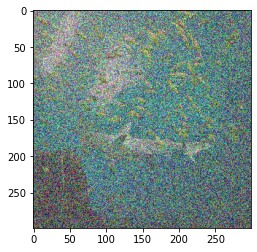

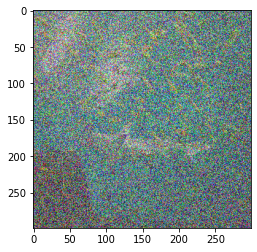

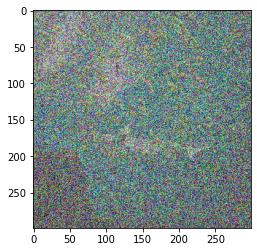

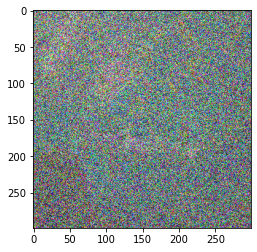

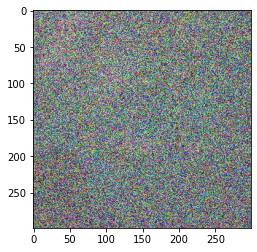

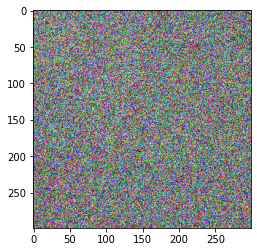

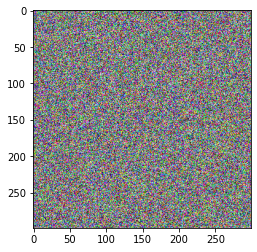

In [42]:
## add random noise and do the same thing
softmax_acc2 = []
softmax_distortion2 = []
rbf_acc2 = []
rbf_distortion2 = []
distortions2 = []
confidence_of_rejection2 = []
alphas = np.linspace(0,1,20)
test_data_generator.batch_size = 100
x_test,y_test = test_data_generator.next()
for i in range(len(alphas)):
  alpha = alphas[i]
  xadv = np.copy(x_test)*(1-alpha) + preprocess(np.random.randint(0,255,(100,299,299,3)))*alpha
  distortion = calc_distortion(xadv,x_test)
  softmax_acc2.append(np.sum(np.argmax(softmax_clean.predict(xadv),axis=1) == np.argmax(y_test,axis=1)) / len(y_test))
  rbf_acc2.append(np.sum(np.argmax(anomaly_clean.predict(xadv),axis=1) == np.argmax(y_test,axis=1)) / len(y_test))
  reject_adv = anomaly_clean.reject(xadv)
  reject_clean = anomaly_clean.reject(x_test)
  confidence_of_rejection2.append([np.mean(reject_adv),np.std(reject_adv)])
  distortions2.append([np.mean(distortion),np.std(distortion)])
  xadv = unprocess(np.copy(xadv)).astype(np.uint8)
  plt.imshow(xadv[0])
  plt.show()
distortions2 = np.array(distortions2)
rbf_acc2 = np.array(rbf_acc2)
softmax_acc2 = np.array(softmax_acc2)
confidence_of_rejection2 = np.array(confidence_of_rejection2)
np.save(os.path.join(attackBaseDir,'softmax_acc2.npy'),softmax_acc2)
np.save(os.path.join(attackBaseDir,'rbf_acc2.npy'),rbf_acc2)
np.save(os.path.join(attackBaseDir,'distortions2.npy'),distortions2)

## Visualize the outcome

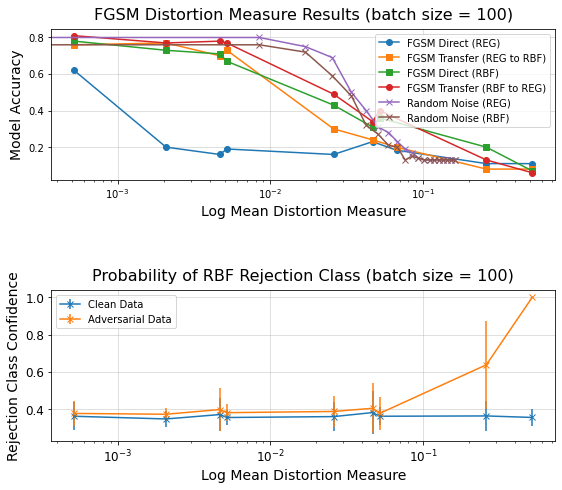

In [44]:
softmax_acc = np.load(os.path.join(attackBaseDir,'softmax_acc.npy'))
rbf_acc = np.load(os.path.join(attackBaseDir,'rbf_acc.npy'))
distortions = np.load(os.path.join(attackBaseDir,'distortions.npy'))
distortions2 = np.load(os.path.join(attackBaseDir,'distortions2.npy'))
confidence_of_clean = np.load(os.path.join(attackBaseDir,'confidence_of_clean.npy'))
confidence_of_rejection = np.load(os.path.join(attackBaseDir,'confidence_of_rejection.npy'))
softmax_acc2 = np.load(os.path.join(attackBaseDir,'softmax_acc2.npy'))
rbf_acc2 = np.load(os.path.join(attackBaseDir,'rbf_acc2.npy'))
a=9
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.errorbar(distortions[a::,0],softmax_acc[a::],label='FGSM Direct (REG)',marker="o")
plt.errorbar(distortions[a::,0],rbf_acc[a::],label='FGSM Transfer (REG to RBF)',marker="s")
plt.errorbar(distortions[0:a,0],rbf_acc[0:a],label='FGSM Direct (RBF)',marker="s")
plt.errorbar(distortions[0:a,0],softmax_acc[0:a],label='FGSM Transfer (RBF to REG)',marker="o")
plt.errorbar(distortions2[:,0],softmax_acc2,label='Random Noise (REG)',marker="x")
plt.errorbar(distortions2[:,0],rbf_acc2,label='Random Noise (RBF)',marker="x")

plt.xscale('log')
plt.legend(loc='upper right',prop={'size': 10})
plt.tight_layout(pad=5)
plt.grid(True,alpha=0.5)
plt.xlabel('Log Mean Distortion Measure',fontsize=14)
plt.ylabel('Model Accuracy',fontsize=14)
plt.title('FGSM Distortion Measure Results (batch size = 100)',fontsize=16,pad=10)

plt.subplot(2,1,2)
plt.errorbar(distortions[0:a,0],confidence_of_clean[0:a,0],yerr=confidence_of_clean[0:a,1],label='Clean Data',marker="x")
plt.errorbar(distortions[0:a,0],confidence_of_rejection[0:a,0],yerr=confidence_of_rejection[0:a,1] ,label='Adversarial Data',marker="x")
#plt.errorbar(distortions2[:,0],confidence_of_rejection2[:,0],yerr=confidence_of_rejection2[:,1] ,label='Random Noise Data',marker="x")

plt.xscale('log')
plt.legend(prop={'size': 10})
plt.grid(True,alpha=0.5)
plt.tick_params(axis='both',labelsize=12)
plt.xlabel('Log Mean Distortion Measure',fontsize=14)
plt.ylabel('Rejection Class Confidence',fontsize=14)
plt.title('Probability of RBF Rejection Class (batch size = 100)',fontsize=16,pad=10)
plt.savefig('/content/meandistortionresults2.eps', format='eps', dpi=1000,bbox_inches='tight')
plt.tight_layout(pad=5)
plt.show()


